# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/automni/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# PPO_EKF_25

|||
|-|-|
| randomize_offset | false |
| horizon | 32768 |
| reward_fn | rw_distance_normalized |
| map | Town01 |

## Full in Town01

In [3]:
# time, frame1_x, frame1_y, frame2_x, frame2_y, ...
trajectories_25 = pd.read_csv('data/PPO_EKF_25/full/town01_2.csv')
trajectories_25.sort_values(by='time', inplace=True)
trajectories_25['time'] -= trajectories_25['time'].min()
trajectories_25.dropna(inplace=True)
print(trajectories_25.shape)
trajectories_25.head()

(38350, 18)


,time,EGO_1/IMU_x,EGO_1/IMU_y,base_link_x,base_link_y,model_frame_x,model_frame_y,EKF_x,EKF_y,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,yaw,speed,steering_angle
6,0.278791,112.379883,2.0481,112.499061,1.668967,111.820255,-29.857633,92.109978,227.219589,-0.149509,-3.999923e-02,9.383371,-9.686973e-07,4.336285e-07,1.075171e-09,90.000267,0.002843,7.0
7,0.339569,112.379883,2.0481,112.499056,1.668968,111.775969,-29.869583,92.109978,227.219589,-0.068775,-3.999962e-02,10.039705,9.387828e-07,-5.432795e-07,-1.756687e-09,90.000267,0.002843,7.0
8,0.373034,112.379883,2.0481,112.499072,1.668968,111.671169,-29.887614,92.109978,227.219422,0.171042,3.999925e-02,9.876070,1.136133e-07,-1.144760e-06,-2.209978e-09,90.000267,0.002357,7.0
9,0.433636,112.379883,2.0481,112.499085,1.668969,111.864601,-29.845712,92.109978,227.219254,0.011047,-4.656613e-10,9.880774,1.051740e-08,-1.167996e-06,1.259320e-09,90.000267,0.000923,7.0
10,0.482967,112.379883,2.0481,112.499133,1.668970,111.770523,-29.867616,92.109978,227.219208,0.010971,-3.999999e-02,9.812336,-9.142648e-07,-1.078526e-06,2.663132e-09,90.000267,0.000923,7.0


In [4]:
# Separate frames
def split_frames(filename: str, frames: list, gt=None):
    df = pd.read_csv(filename)
    df.sort_values(by='time', inplace=True)
    df['time'] -= df['time'].min()
    # df.dropna(inplace=True)

    result = {}
    gt_df = None
    if gt is not None and gt in frames:
        gt_df = df[['time', f'{gt}_x', f'{gt}_y']].rename(columns={f'{gt}_x': 'x', f'{gt}_y': 'y'})
        gt_df['y'] = -gt_df['y']
    for frame in frames:
        frame_df = df[['time', f'{frame}_x', f'{frame}_y']].rename(columns={f'{frame}_x': 'x', f'{frame}_y': 'y'})
        frame_df['y'] = -frame_df['y']
        if gt_df is not None:
            frame_df['error_x'] = frame_df['x'] - gt_df['x']
            frame_df['error_y'] = frame_df['y'] - gt_df['y']
            frame_df['error'] = np.sqrt(frame_df['error_x']**2 + frame_df['error_y']**2)
        # frame_df.dropna(inplace=True)
        result[frame] = frame_df
    return result

In [5]:
frames_df = split_frames(
    'data/PPO_EKF_25/full/town01_2.csv',
    ['EGO_1/IMU', 'base_link', 'model_frame'],
    gt='EGO_1/IMU'
)
gt_25, EKF_25, model_25 = frames_df['EGO_1/IMU'], frames_df['base_link'], frames_df['model_frame']
print(gt_25.shape, EKF_25.shape, model_25.shape)
gt_25.head(), EKF_25.head(), model_25.head()

(38356, 6) (38356, 6) (38356, 6)


(       time           x       y  error_x  error_y  error
 0  0.000000  112.379883 -2.0481      0.0      0.0    0.0
 1  0.026820  112.379883 -2.0481      0.0      0.0    0.0
 2  0.082870  112.379883 -2.0481      0.0      0.0    0.0
 3  0.139304  112.379883 -2.0481      0.0      0.0    0.0
 4  0.189592  112.379883 -2.0481      0.0      0.0    0.0,
        time           x         y   error_x   error_y     error
 0  0.000000  112.498758 -1.668962  0.118875  0.379137  0.397337
 1  0.026820  112.498753 -1.668962  0.118871  0.379137  0.397335
 2  0.082870  112.498836 -1.668963  0.118953  0.379136  0.397359
 3  0.139304  112.498867 -1.668964  0.118984  0.379136  0.397368
 4  0.189592  112.499055 -1.668966  0.119172  0.379133  0.397422,
        time           x          y   error_x    error_y      error
 0  0.000000  112.198089  29.799995 -0.181794  31.848094  31.848613
 1  0.026820  112.198089  29.799995 -0.181794  31.848094  31.848613
 2  0.082870  111.585540  29.899177 -0.794343  31.947276

## Line in real life (rosbag2_2025_06_27-19_29_33)

Controle manual longo

In [6]:
frames_df = split_frames(
    'data/PPO_EKF_25/real/trajectories.csv',
    ['base_link', 'model_frame']
)
EKF_real, model_real = frames_df['base_link'], frames_df['model_frame']
EKF_real.head(), model_real.head()

(       time   x   y
 0  0.000000 NaN NaN
 1  0.050026 NaN NaN
 2  0.099714 NaN NaN
 3  0.149724 NaN NaN
 4  0.199996 NaN NaN,
        time   x   y
 0  0.000000 NaN NaN
 1  0.050026 NaN NaN
 2  0.099714 NaN NaN
 3  0.149724 NaN NaN
 4  0.199996 NaN NaN)

## Circle in real life (rosbag2_2025_06_29-22_05_28)

In [7]:
frames_df = split_frames(
    'data/PPO_EKF_25/real/curve_ekf.csv',
    ['base_link', 'model_frame']
)
EKF_curve, model_curve = frames_df['base_link'], frames_df['model_frame']
EKF_curve.head(), model_curve.head()

(       time   x   y
 0  0.000000 NaN NaN
 1  0.049873 NaN NaN
 2  0.099929 NaN NaN
 3  0.149904 NaN NaN
 4  0.199825 NaN NaN,
        time   x   y
 0  0.000000 NaN NaN
 1  0.049873 NaN NaN
 2  0.099929 NaN NaN
 3  0.149904 NaN NaN
 4  0.199825 NaN NaN)

# Figures

## Trajectory excerpt

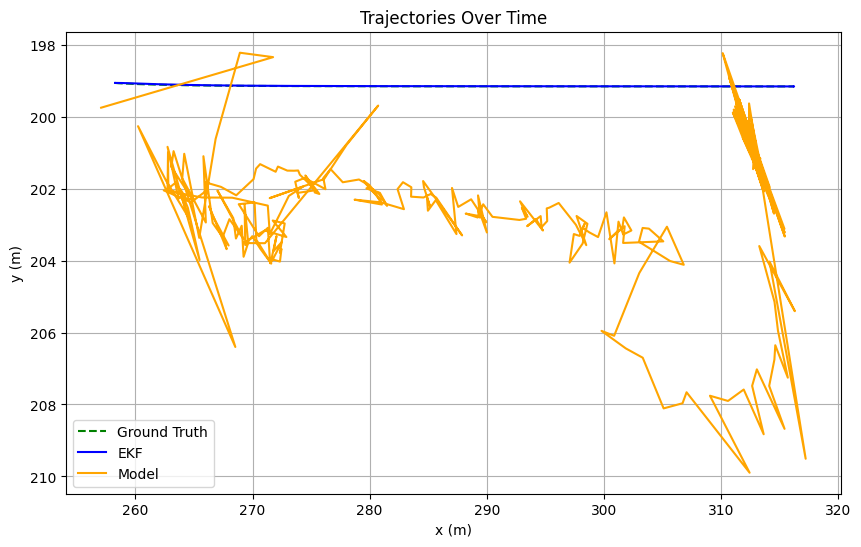

In [8]:
# Plot trajectories over specified horizon
# t0 = 140
# t1 = 160
t0 = 361
t1 = 380
error_threshold = 10.0
mask = lambda df: (df['time'] >= t0) & (df['time'] <= t1) & (EKF_25['error'] <= error_threshold)

def masked_xy(df):
    m = mask(df)
    x = df['x'].copy()
    y = df['y'].copy()
    x[~m] = np.nan
    y[~m] = np.nan
    return x, y

plt.figure(figsize=(10, 6))
x_gt, y_gt = masked_xy(gt_25)
x_ekf, y_ekf = masked_xy(EKF_25)
x_model, y_model = masked_xy(model_25)
plt.plot(x_gt, y_gt, label='Ground Truth', color='green', linestyle='--')
plt.plot(x_ekf, y_ekf, label='EKF', color='blue')
plt.plot(x_model, y_model, label='Model', color='orange')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().invert_yaxis()
plt.title('Trajectories Over Time')
plt.legend()
plt.grid()
plt.show()

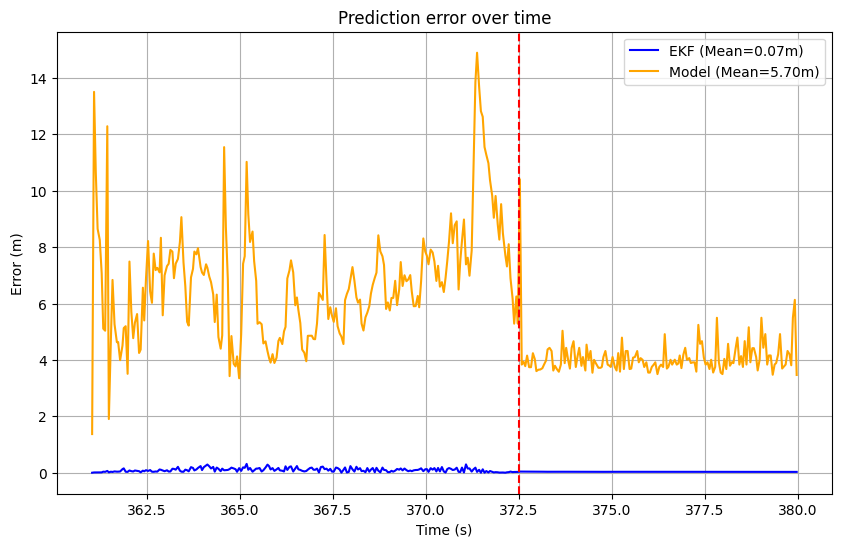

In [9]:
# Plot errors over time
def masked_time_error(df):
    m = mask(df)
    t = df['time'].copy()
    e = df['error'].copy()
    t[~m] = np.nan
    e[~m] = np.nan
    return t, e

plt.figure(figsize=(10, 6))
t_ekf, error_ekf = masked_time_error(EKF_25)
t_model, error_model = masked_time_error(model_25)
plt.plot(t_ekf, error_ekf, label=f"EKF (Mean={error_ekf.mean():.2f}m)", color='blue')
plt.plot(t_model, error_model, label=f"Model (Mean={error_model.mean():.2f}m)", color='orange')
# Vertical red dotted line at t=372.5
plt.axvline(x=372.5, color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Error (m)')
plt.title('Prediction error over time')
plt.legend()
plt.grid()
plt.show()

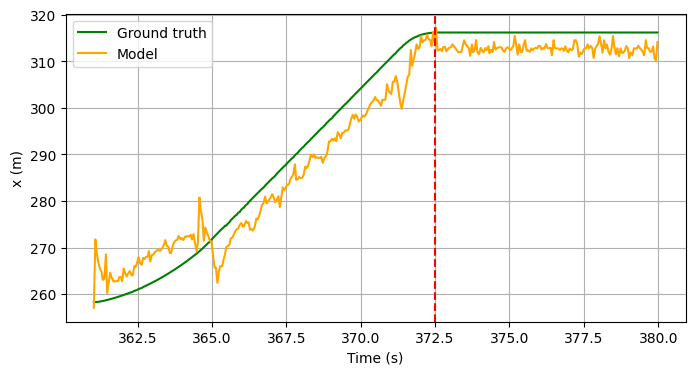

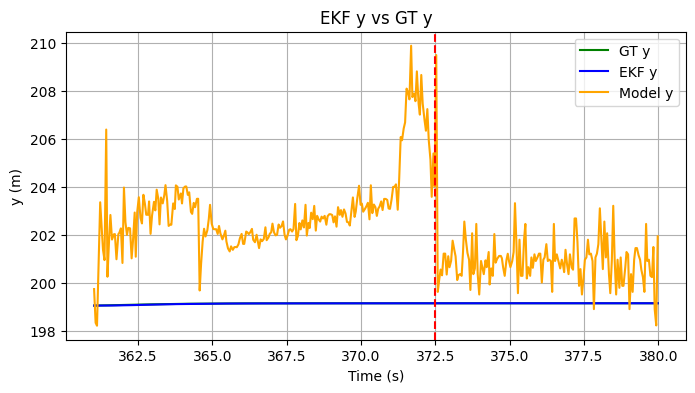

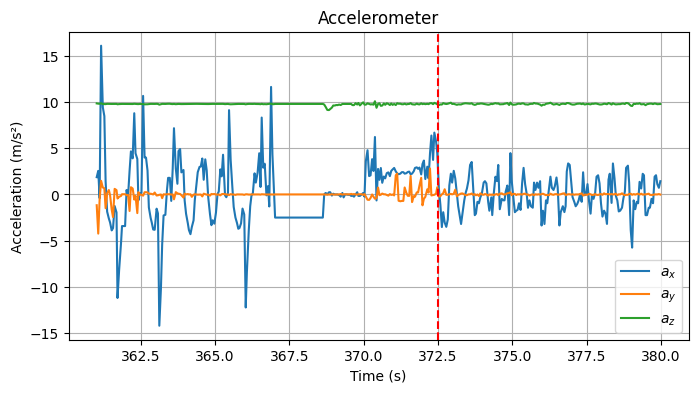

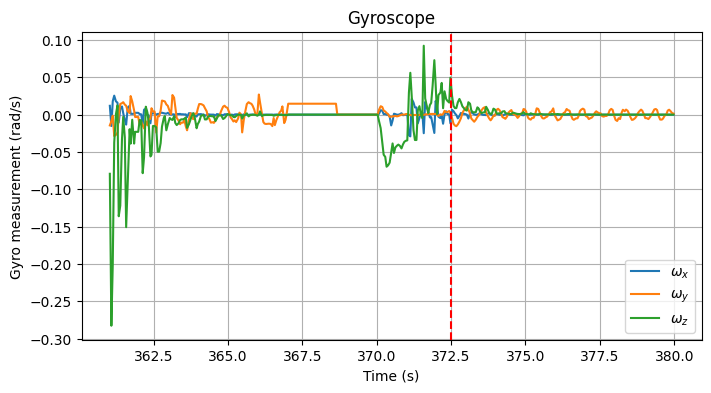

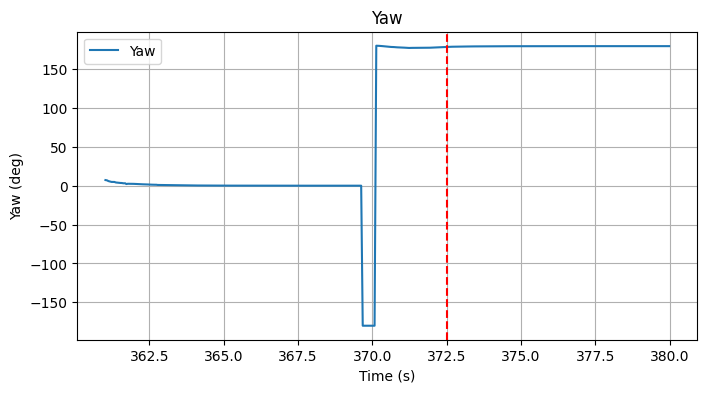

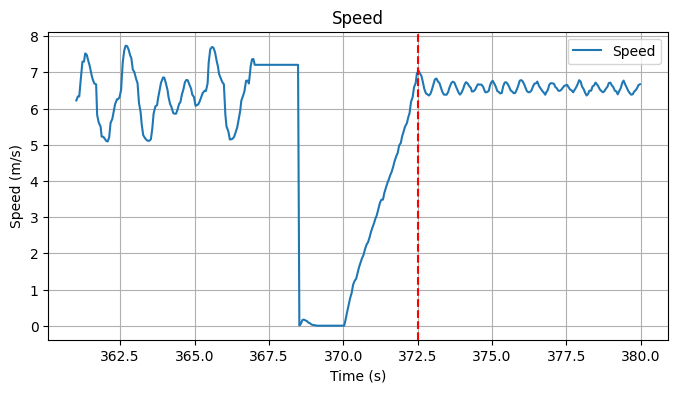

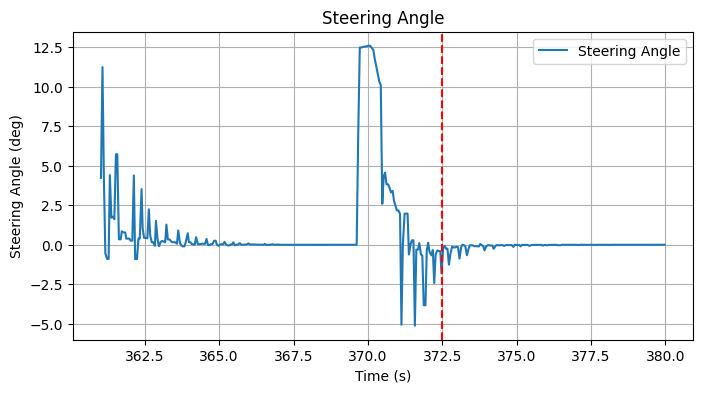

In [10]:
# Plot 1: EKF_x vs GT_x
def masked_time_val(df, col):
    m = mask(df)
    t = df['time'].copy()
    v = df[col].copy()
    t[~m] = np.nan
    v[~m] = np.nan
    return t, v

plt.figure(figsize=(8, 4))
t_gt, x_gt = masked_time_val(gt_25, 'x')
t_ekf, x_ekf = masked_time_val(EKF_25, 'x')
t_model, x_model = masked_time_val(model_25, 'x')
plt.plot(t_gt, x_gt, label='Ground truth', color='green')
# plt.plot(t_ekf, x_ekf, label='EKF x', color='blue')
plt.plot(t_model, x_model, label='Model', color='orange')
plt.axvline(x=372.5, color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('x (m)')
plt.title('')
plt.legend()
plt.grid()
plt.show()

# Plot 2: EKF_y vs GT_y
plt.figure(figsize=(8, 4))
t_gt, y_gt = masked_time_val(gt_25, 'y')
t_ekf, y_ekf = masked_time_val(EKF_25, 'y')
t_model, y_model = masked_time_val(model_25, 'y')
plt.plot(t_gt, y_gt, label='GT y', color='green')
plt.plot(t_ekf, y_ekf, label='EKF y', color='blue')
plt.plot(t_model, y_model, label='Model y', color='orange')
plt.axvline(x=372.5, color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('y (m)')
plt.title('EKF y vs GT y')
plt.legend()
plt.grid()
plt.show()

# Plot 3: acc_{x,y,z}
def masked_time_val_traj(col):
    m = mask(trajectories_25)
    t = trajectories_25['time'].copy()
    v = trajectories_25[col].copy()
    t[~m] = np.nan
    v[~m] = np.nan
    return t, v

plt.figure(figsize=(8, 4))
for acc, label in zip(['acc_x', 'acc_y', 'acc_z'], ['$a_x$', '$a_y$', '$a_z$']):
    t, v = masked_time_val_traj(acc)
    plt.plot(t, v, label=label)
plt.axvline(x=372.5, color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.title('Accelerometer')
plt.legend()
plt.grid()
plt.show()

# Plot 4: gyro_{x,y,z}
plt.figure(figsize=(8, 4))
for gyro, label in zip(['gyro_x', 'gyro_y', 'gyro_z'], ['$\\omega_x$', '$\\omega_y$', '$\\omega_z$']):
    t, v = masked_time_val_traj(gyro)
    plt.plot(t, v, label=label)
plt.axvline(x=372.5, color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Gyro measurement (rad/s)')
plt.title('Gyroscope')
plt.legend()
plt.grid()
plt.show()

# Plot 5: Yaw
plt.figure(figsize=(8, 4))
t, yaw = masked_time_val_traj('yaw')
plt.plot(t, yaw, label='Yaw')
plt.axvline(x=372.5, color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Yaw (deg)')
plt.title('Yaw')
plt.legend()
plt.grid()
plt.show()

# Plot 6: Speed
plt.figure(figsize=(8, 4))
t, speed = masked_time_val_traj('speed')
plt.plot(t, speed, label='Speed')
plt.axvline(x=372.5, color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.title('Speed')
plt.legend()
plt.grid()
plt.show()

# Plot 7: Steering angle
plt.figure(figsize=(8, 4))
t, steering = masked_time_val_traj('steering_angle')
plt.plot(t, steering, label='Steering Angle')
plt.axvline(x=372.5, color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Steering Angle (deg)')
plt.title('Steering Angle')
plt.legend()
plt.grid()
plt.show()

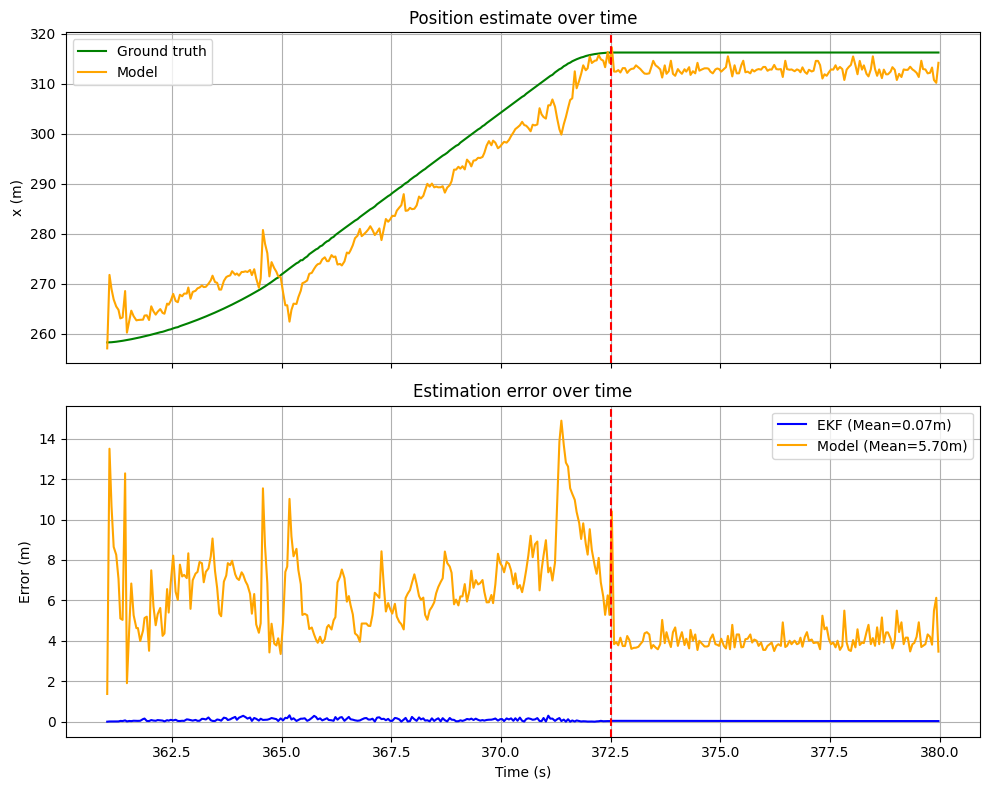

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot 1: x over time
t_gt, x_gt = masked_time_val(gt_25, 'x')
t_model, x_model = masked_time_val(model_25, 'x')
axs[0].plot(t_gt, x_gt, label='Ground truth', color='green')
axs[0].plot(t_model, x_model, label='Model', color='orange')
axs[0].axvline(x=372.5, color='red', linestyle='--')
axs[0].set_ylabel('x (m)')
axs[0].set_title('Position estimate over time')
axs[0].legend()
axs[0].grid()

# Plot 2: error over time
t_ekf, error_ekf = masked_time_error(EKF_25)
t_model, error_model = masked_time_error(model_25)
axs[1].plot(t_ekf, error_ekf, label=f"EKF (Mean={error_ekf.mean():.2f}m)", color='blue')
axs[1].plot(t_model, error_model, label=f"Model (Mean={error_model.mean():.2f}m)", color='orange')
axs[1].axvline(x=372.5, color='red', linestyle='--')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Error (m)')
axs[1].set_title('Estimation error over time')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


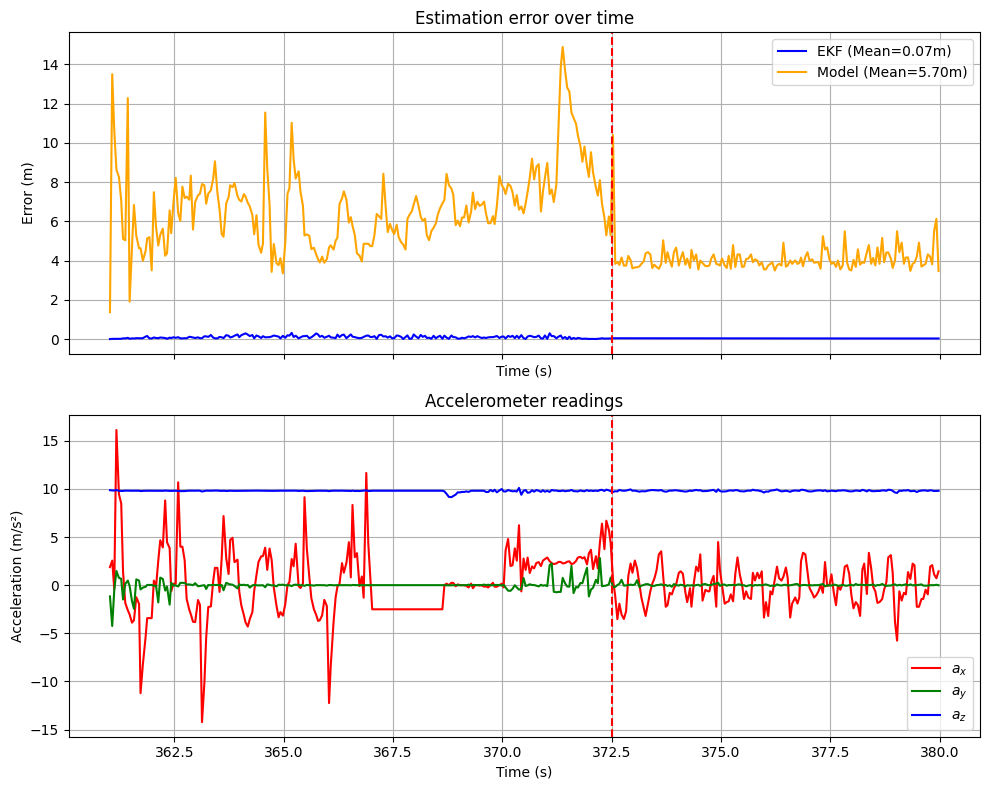

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot 1: error over time
t_ekf, error_ekf = masked_time_error(EKF_25)
t_model, error_model = masked_time_error(model_25)
axs[0].plot(t_ekf, error_ekf, label=f"EKF (Mean={error_ekf.mean():.2f}m)", color='blue')
axs[0].plot(t_model, error_model, label=f"Model (Mean={error_model.mean():.2f}m)", color='orange')
axs[0].axvline(x=372.5, color='red', linestyle='--')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Error (m)')
axs[0].set_title('Estimation error over time')
axs[0].legend()
axs[0].grid()

# Plot 2: acceleration over time
t_acc, acc_x = masked_time_val_traj('acc_x')
_, acc_y = masked_time_val_traj('acc_y')
_, acc_z = masked_time_val_traj('acc_z')
axs[1].plot(t_acc, acc_x, label='$a_x$', color='red')
axs[1].plot(t_acc, acc_y, label='$a_y$', color='green')
axs[1].plot(t_acc, acc_z, label='$a_z$', color='blue')
axs[1].axvline(x=372.5, color='red', linestyle='--')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Acceleration (m/s²)')
axs[1].set_title('Accelerometer readings')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


## real

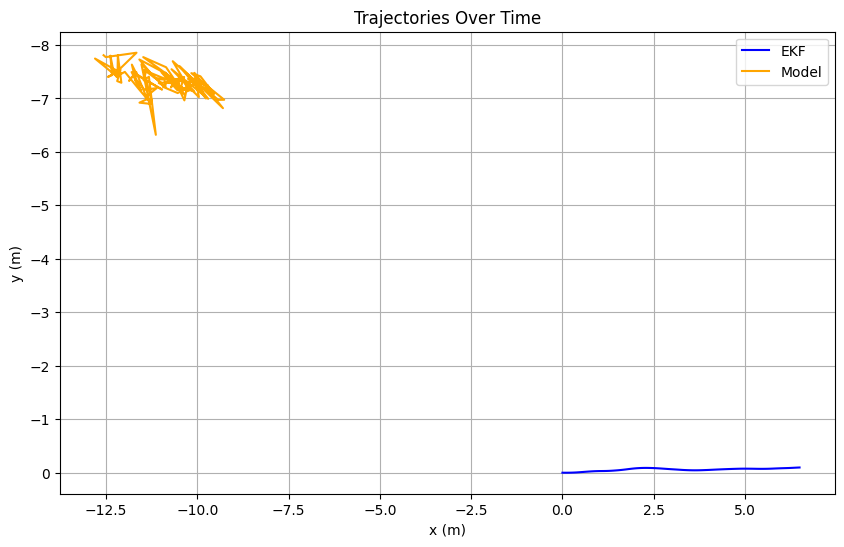

In [8]:
# Plot trajectories over specified horizon
# t0 = 140
# t1 = 160
t0 = 12
t1 = 17.5
mask_EKF = (EKF_real['time'] >= t0) & (EKF_real['time'] <= t1)
mask_model = (model_real['time'] >= t0) & (model_real['time'] <= t1)

plt.figure(figsize=(10, 6))
plt.plot(EKF_real['x'][mask_EKF], EKF_real['y'][mask_EKF], label='EKF', color='blue')
plt.plot(model_real['x'][mask_model], model_real['y'][mask_model], label='Model', color='orange')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().invert_yaxis()
plt.title('Trajectories Over Time')
plt.legend()
plt.grid()
plt.show()

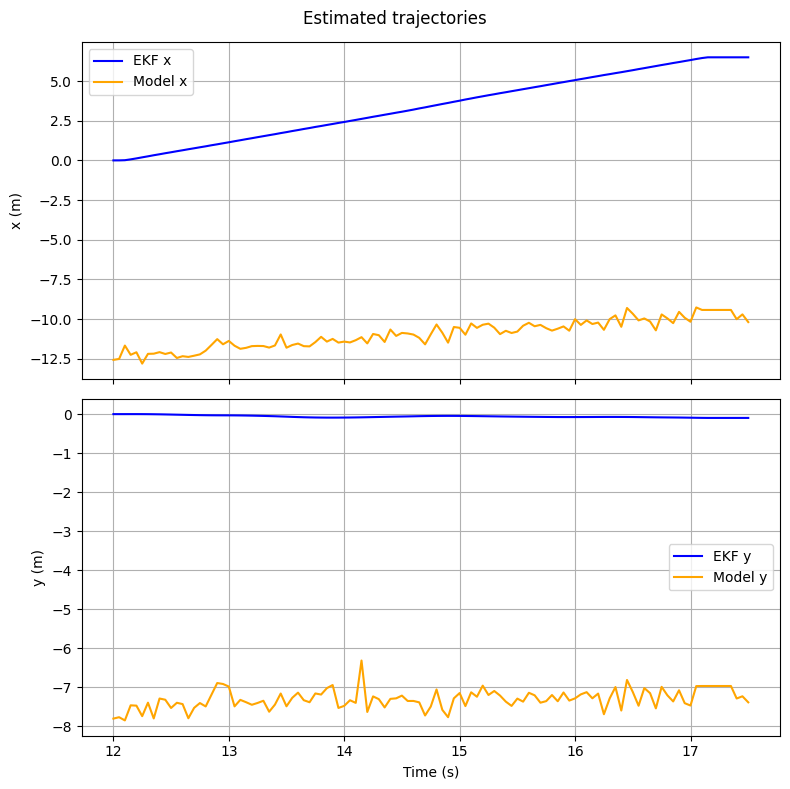

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
fig.suptitle('Estimated trajectories')

axs[0].plot(EKF_real['time'][mask_EKF], EKF_real['x'][mask_EKF], label='EKF x', color='blue')
axs[0].plot(model_real['time'][mask_model], model_real['x'][mask_model], label='Model x', color='orange')
axs[0].set_ylabel('x (m)')
axs[0].legend()
axs[0].grid()

axs[1].plot(EKF_real['time'][mask_EKF], EKF_real['y'][mask_EKF], label='EKF y', color='blue')
axs[1].plot(model_real['time'][mask_model], model_real['y'][mask_model], label='Model y', color='orange')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('y (m)')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

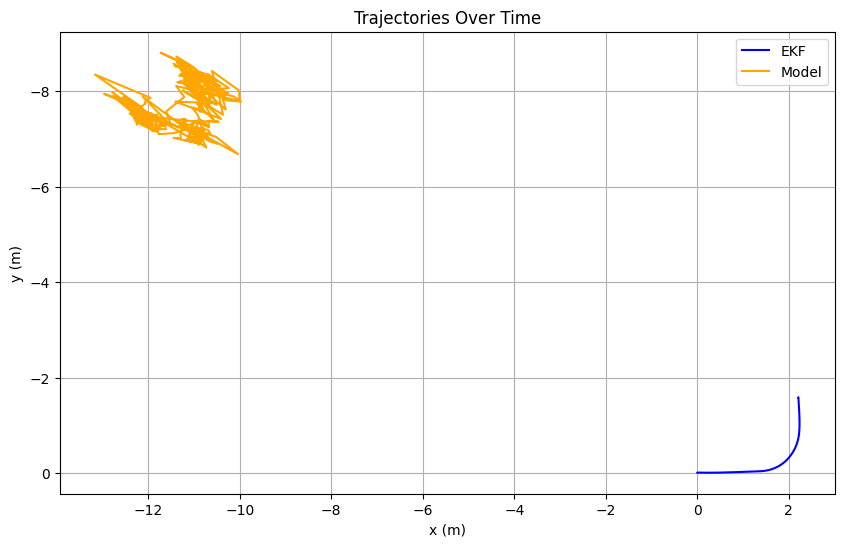

In [19]:
# Plot trajectories over specified horizon
t0 = 0
t1 = 250
mask_EKF = (EKF_curve['time'] >= t0) & (EKF_curve['time'] <= t1)
mask_model = (model_curve['time'] >= t0) & (model_curve['time'] <= t1)

plt.figure(figsize=(10, 6))
plt.plot(EKF_curve['x'][mask_EKF], EKF_curve['y'][mask_EKF], label='EKF', color='blue')
plt.plot(model_curve['x'][mask_model], model_curve['y'][mask_model], label='Model', color='orange')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().invert_yaxis()
plt.title('Trajectories Over Time')
plt.legend()
plt.grid()
plt.show()

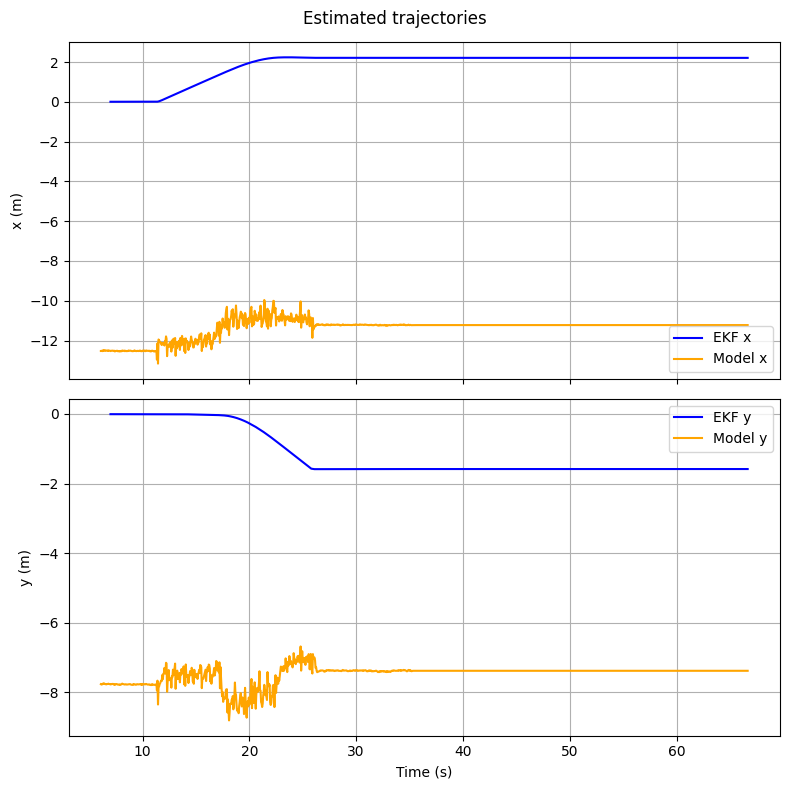

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
fig.suptitle('Estimated trajectories')

axs[0].plot(EKF_curve['time'][mask_EKF], EKF_curve['x'][mask_EKF], label='EKF x', color='blue')
axs[0].plot(model_curve['time'][mask_model], model_curve['x'][mask_model], label='Model x', color='orange')
axs[0].set_ylabel('x (m)')
# axs[0].set_title('EKF x vs Model x')
axs[0].legend()
axs[0].grid()

axs[1].plot(EKF_curve['time'][mask_EKF], EKF_curve['y'][mask_EKF], label='EKF y', color='blue')
axs[1].plot(model_curve['time'][mask_model], model_curve['y'][mask_model], label='Model y', color='orange')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('y (m)')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

In [15]:
def interpolate_segment(start, end, resolution):
        x0, y0 = start
        x1, y1 = end
        dist = np.hypot(x1 - x0, y1 - y0)
        steps = max(2, int(dist / resolution))
        return [(x0 + (x1 - x0) * i / steps, y0 + (y1 - y0) * i / steps) for i in range(steps)]

def arc(cx, cy, start_angle, end_angle, radius, resolution):
    steps = max(4, int(abs(end_angle - start_angle) * radius / resolution))
    return [(cx + radius * np.cos(a), cy + radius * np.sin(a))
            for a in [start_angle + (end_angle - start_angle) * i / steps for i in range(steps)]]

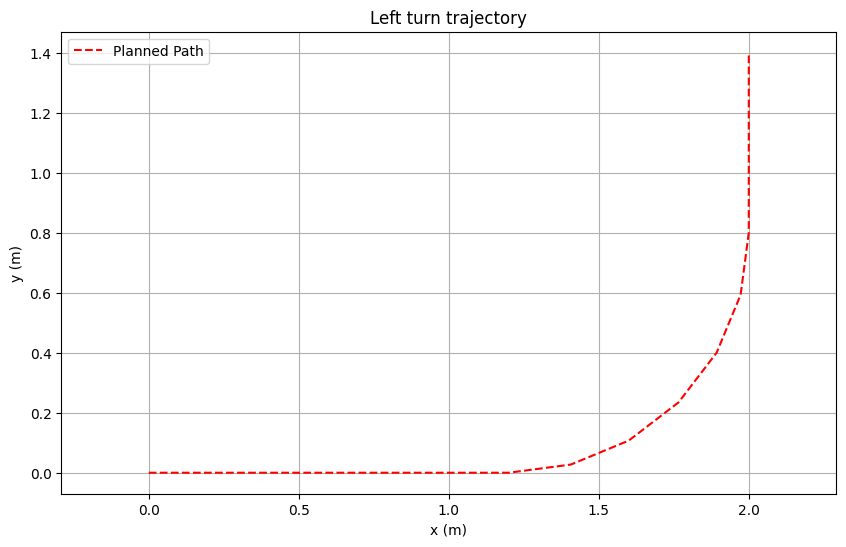

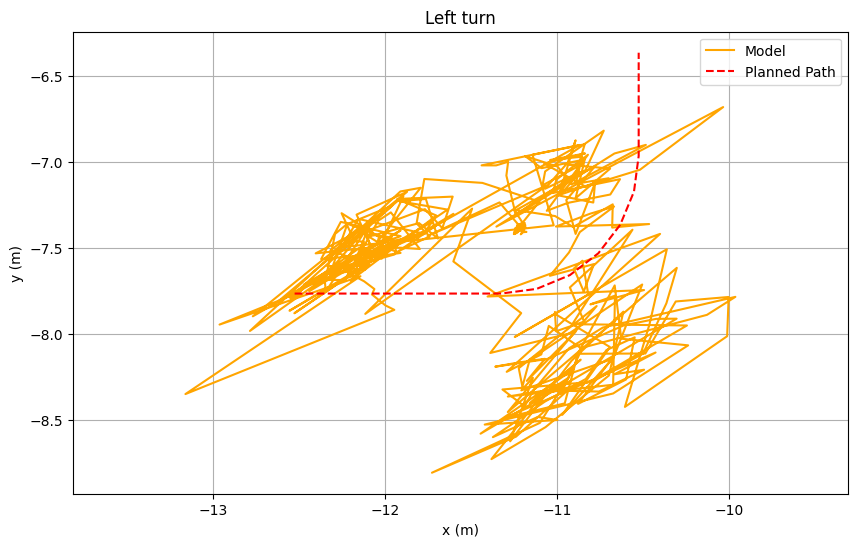

In [31]:
L = 2.0
r = 0.8
resolution = 0.2
segments = []
segments += interpolate_segment((0, 0), (L - r, 0), resolution)
segments += arc(L - r, r, -np.pi / 2, 0.0, r, resolution)
segments += interpolate_segment((L, r), (L, L - 0.5*r), resolution)

# Plot the segments
x_vals = [x for x, y in segments]
y_vals = [y for x, y in segments]
plt.figure(figsize=(10, 6))
# plt.plot(EKF_curve['x'][mask_EKF], -EKF_curve['y'][mask_EKF], label='EKF', color='blue')
# plt.plot(model_curve['x'][mask_model], model_curve['y'][mask_model], label='Model', color='orange')
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Planned Path')
plt.title("Left turn trajectory")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.axis('equal')
plt.grid()
plt.legend()
plt.show()

# Plot the segments
x_vals = [x + model_curve['x'].dropna().iloc[0] for x, y in segments]
y_vals = [y + model_curve['y'].dropna().iloc[0] for x, y in segments]
plt.figure(figsize=(10, 6))
# plt.plot(EKF_curve['x'][mask_EKF], -EKF_curve['y'][mask_EKF], label='EKF', color='blue')
plt.plot(model_curve['x'][mask_model], model_curve['y'][mask_model], label='Model', color='orange')
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Planned Path')
plt.title("Left turn")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.axis('equal')
plt.grid()
plt.legend()
plt.show()


np.float64(-12.526679039001465)

## Heatmaps

In [23]:
# Plot a heatmap of mean model error, with empty bins shown as white
def heatmap(x, y, errors, bins, title):
    sum_errors, xedges, yedges = np.histogram2d(
        x, y,
        bins=bins,
        weights=errors
    )
    counts, _, _ = np.histogram2d(
        x, y,
        bins=[xedges, yedges]
    )
    mean_errors = np.divide(sum_errors, counts, out=np.zeros_like(sum_errors), where=counts > 0)
    mean_errors[counts == 0] = np.nan

    cmap = plt.get_cmap('plasma').copy()
    cmap.set_bad('white')

    plt.figure(figsize=(10, 8))
    plt.imshow(
        mean_errors.T,
        origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        aspect='auto',
        cmap=cmap
    )
    plt.colorbar(label='Mean Error (m)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.grid()
    plt.show()


EKF:
	Mean: 0.978 m
	Std: 1.158 m
	Max: 9.985 m
Model:
	Mean: 25.478 m
	Std: 18.535 m
	Max: 535.431 m


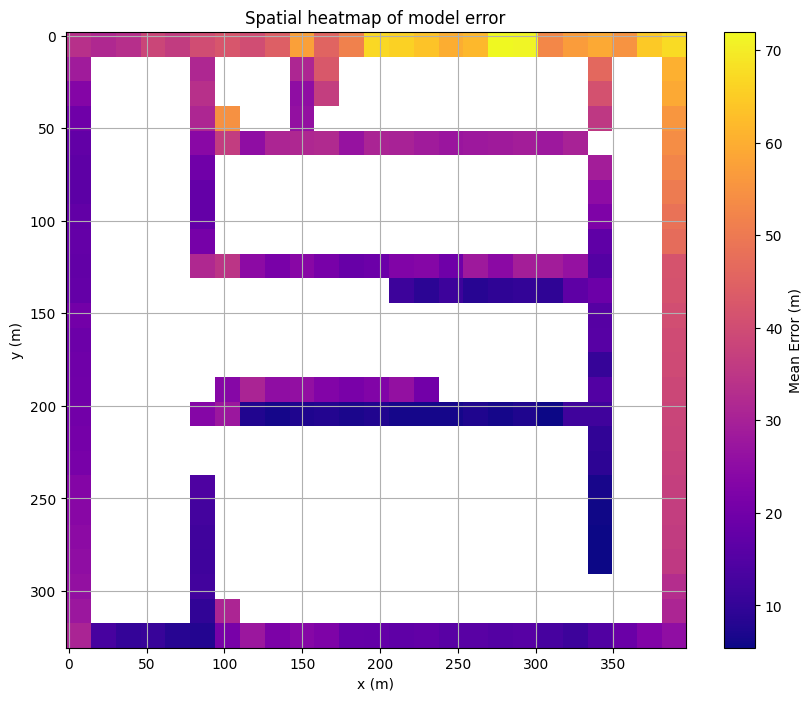

In [46]:
files = [
    'data/PPO_EKF_25/full/town01_1.csv',
    'data/PPO_EKF_25/full/town01_2.csv',
    'data/PPO_EKF_25/full/town01_3.csv',
    'data/PPO_EKF_25/full/town01_4.csv',
]
gt = []
EKF = []
model = []
for file in files:
    frames = split_frames(file, ['EGO_1/IMU', 'base_link', 'model_frame'], gt='EGO_1/IMU')
    gt.append(frames['EGO_1/IMU'])
    EKF.append(frames['base_link'])
    model.append(frames['model_frame'])

# Concatenate the dataframes for comparison
gt_25_combined = pd.concat(gt, ignore_index=True)
EKF_25_combined = pd.concat(EKF, ignore_index=True)
model_25_combined = pd.concat(model, ignore_index=True)

# Apply mask for error threshold and time window
t0 = 0
t1 = 60000
error_threshold = 10.0
mask_combined = (gt_25_combined['time'] >= t0) & (gt_25_combined['time'] <= t1) & (EKF_25_combined['error'] <= error_threshold)

print(f"EKF:\n\tMean: {EKF_25_combined['error'][mask_combined].mean():.3f} m\n\tStd: {EKF_25_combined['error'][mask_combined].std():.3f} m\n\tMax: {EKF_25_combined['error'][mask_combined].max():.3f} m")
print(f"Model:\n\tMean: {model_25_combined['error'][mask_combined].mean():.3f} m\n\tStd: {model_25_combined['error'][mask_combined].std():.3f} m\n\tMax: {model_25_combined['error'][mask_combined].max():.3f} m")

heatmap(
    gt_25_combined['x'][mask_combined],
    gt_25_combined['y'][mask_combined],
    model_25_combined['error'][mask_combined],
    25,
    title="Spatial heatmap of model error"
)

EKF:
	Mean: 1.039 m
	Std: 1.487 m
	Max: 9.990 m
Model:
	Mean: 17.063 m
	Std: 12.626 m
	Max: 423.251 m


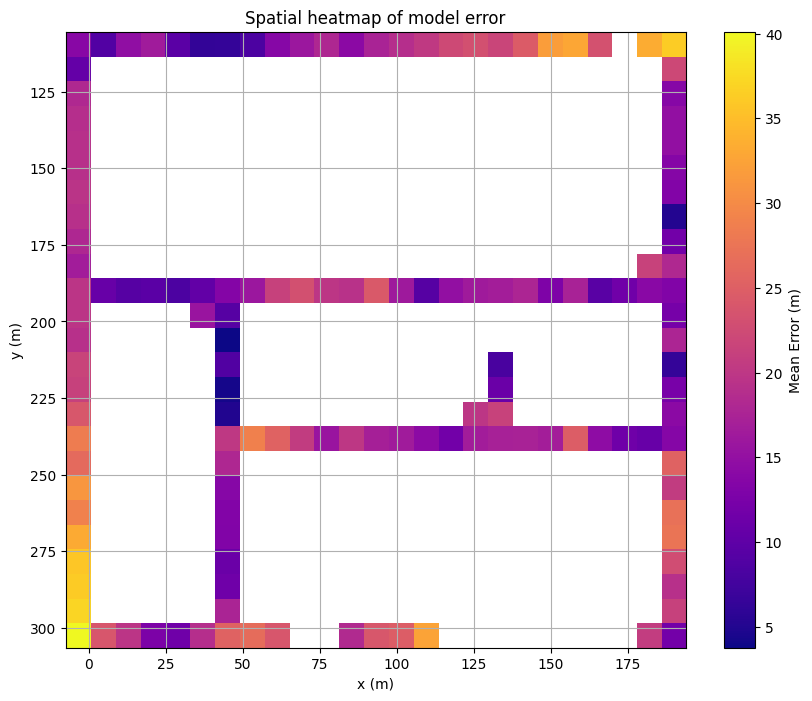

In [43]:
files = [
    'data/PPO_EKF_25/full/town02_1.csv',
    'data/PPO_EKF_25/full/town02_2.csv',
    'data/PPO_EKF_25/full/town02_3.csv',
]
gt = []
EKF = []
model = []
for file in files:
    frames = split_frames(file, ['EGO_1/IMU', 'base_link', 'model_frame'], gt='EGO_1/IMU')
    gt.append(frames['EGO_1/IMU'])
    EKF.append(frames['base_link'])
    model.append(frames['model_frame'])

# Concatenate the dataframes for comparison
gt_25_combined = pd.concat(gt, ignore_index=True)
EKF_25_combined = pd.concat(EKF, ignore_index=True)
model_25_combined = pd.concat(model, ignore_index=True)

# Apply mask for error threshold and time window
t0 = 0
t1 = 60000
error_threshold = 10.0
mask_combined = (gt_25_combined['time'] >= t0) & (gt_25_combined['time'] <= t1) & (EKF_25_combined['error'] <= error_threshold)

print(f"EKF:\n\tMean: {EKF_25_combined['error'][mask_combined].mean():.3f} m\n\tStd: {EKF_25_combined['error'][mask_combined].std():.3f} m\n\tMax: {EKF_25_combined['error'][mask_combined].max():.3f} m")
print(f"Model:\n\tMean: {model_25_combined['error'][mask_combined].mean():.3f} m\n\tStd: {model_25_combined['error'][mask_combined].std():.3f} m\n\tMax: {model_25_combined['error'][mask_combined].max():.3f} m")

heatmap(
    gt_25_combined['x'][mask_combined],
    gt_25_combined['y'][mask_combined],
    model_25_combined['error'][mask_combined],
    25,
    title="Spatial heatmap of model error"
)